## Objective of This Notebook

The objective of this notebook is to provide a deep understanding of the K-Nearest Neighbors (KNN) algorithm by comparing manual implementation techniques with optimized machine learning library functions.

- First, I will demonstrate how to manually implement KNN for regression tasks, calculating distances, sorting neighbors, and making predictions without relying on external libraries.
- Next, I will apply the same methodology using the scikit-learn library, allowing for a direct comparison between manual and automated approaches.

Finally, I will conclude by discussing the importance of understanding foundational algorithms like KNN for building a solid machine learning background and highlight how mastering these fundamentals is critical for advancing toward more complex AI applications.

📚 GitHub: https://github.com/MaxWienandts/KNN_Manual_vs_ScikitLearn/tree/main \
📖 Medium Article: https://medium.com/@maxwienandts/mastering-k-nearest-neighbors-knn-from-manual-implementation-to-real-world-applications-a61e8c181906

## About KNN

K-Nearest Neighbors (KNN) is a simple, intuitive, and powerful machine learning algorithm \
used for classification and regression. It works by finding the 'k' closest training examples \
to a new input and predicting the output based on these neighbors.

KNN doesn't make assumptions about the underlying distribution of the data or the form of the relationship between input features and output. Instead, it relies directly on the data to make predictions.

Key points:
- KNN is a supervised model.
- KNN is a non-parametric learning algorithm.
- KNN is a lazy learner: it doesn't explicitly learn a model, it memorizes the training set.
- It uses distance metrics (commonly Euclidean distance) to determine similarity.
- It is sensitive to the choice of 'k' and to feature scaling.

In [1]:
import math
import random

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

In [2]:
# Data from: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
# SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
# GrLivArea: Above-ground living area (in square feet)
# GarageArea: Garage size (in square feet)
df = pd.read_csv("./data/train.csv", usecols = ['Id', 'SalePrice', 'GrLivArea', 'GarageArea'])
df

,Id,GrLivArea,GarageArea,SalePrice
0,1,1710,548,208500
1,2,1262,460,181500
2,3,1786,608,223500
3,4,1717,642,140000
4,5,2198,836,250000
...,...,...,...,...
1455,1456,1647,460,175000
1456,1457,2073,500,210000
1457,1458,2340,252,266500
1458,1459,1078,240,142125


## Initial Checks
I am not focusing on exploratory data analysis (EDA) in this notebook. However, I will perform some basic data checks to identify any potential issues with the dataset.

Specifically, I want to verify:
- that all data types are correct (e.g., no unexpected characters in numeric variables),
- that there are no missing values,
- and that the variables exhibit some variance.

In [3]:
# Verify data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Id          1460 non-null   int64
 1   GrLivArea   1460 non-null   int64
 2   GarageArea  1460 non-null   int64
 3   SalePrice   1460 non-null   int64
dtypes: int64(4)
memory usage: 45.8 KB


In [4]:
# Missing values
df_missing = pd.DataFrame(df.isna().sum(), columns = ['missing_values'])
df_missing['percent'] = df_missing['missing_values'] / len(df)
df_missing.head(50)

,missing_values,percent
Id,0,0.0
GrLivArea,0,0.0
GarageArea,0,0.0
SalePrice,0,0.0


In [5]:
# Describe
df.describe()

,Id,GrLivArea,GarageArea,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,1515.463699,472.980137,180921.195890
std,421.610009,525.480383,213.804841,79442.502883
min,1.000000,334.000000,0.000000,34900.000000
25%,365.750000,1129.500000,334.500000,129975.000000
50%,730.500000,1464.000000,480.000000,163000.000000
75%,1095.250000,1776.750000,576.000000,214000.000000
max,1460.000000,5642.000000,1418.000000,755000.000000


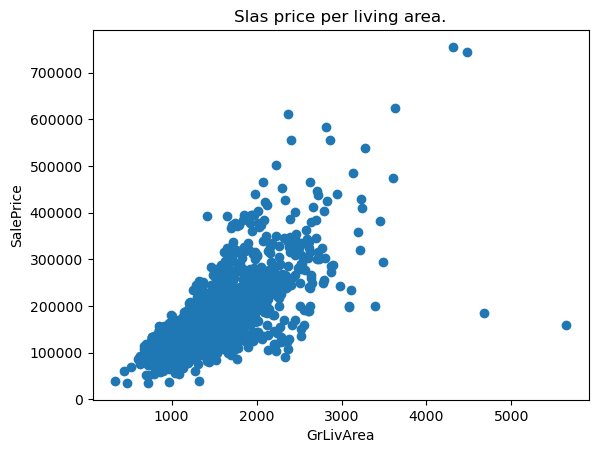

In [6]:
# Plot
# GrLivArea
X = df['GrLivArea']
y = df['SalePrice']
plt.scatter(X, y, label="Data")
plt.xlabel(f"GrLivArea")
plt.ylabel(f"SalePrice")
plt.title("Slas price per living area.")
plt.show()

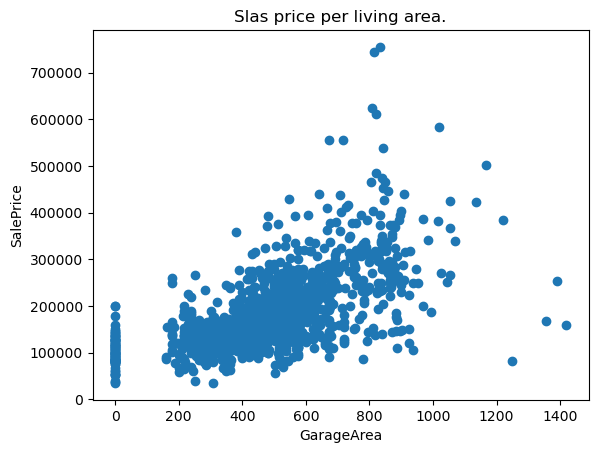

In [7]:
# Plot
# GarageArea
X = df['GarageArea']
y = df['SalePrice']
plt.scatter(X, y, label="Data")
plt.xlabel(f"GarageArea")
plt.ylabel(f"SalePrice")
plt.title("Slas price per living area.")
plt.show()

## Manual implementation of KNN

Now, let's walk step-by-step through how K-Nearest Neighbors works manually:

1. **Distance Calculation**:
   For each point in the training data, we compute the distance between the training point \
   and the new point we want to predict. Here, we use the Euclidean distance formula:

$$ 
\text{distance} = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2} 
$$

   where (x1, y1) is a point in the training set, and (x2, y2) is the new point.

2. **Sorting the Distances**:
   After computing the distance from each training point to the new point, \
   we sort these distances from smallest to largest.

3. **Selecting the K Nearest Neighbors**:
   We pick the 'k' points with the smallest distances. In our case, k=1, \
   meaning we just take the single closest neighbor.

4. **Prediction**:
   - For classification: we would pick the most frequent class among the neighbors.
   - For regression: we take the average (mean) of the neighbors' target values.

Since we are predicting SalePrice (a continuous value), we will average the neighbor values. \
If k=1, we simply return the SalePrice of the closest neighbor.

**Important Considerations about Choosing 'k':**

Choosing the right 'k' is crucial for KNN performance:
- If 'k' is too small (e.g., k=1), the model can be very sensitive to noise (overfitting).
- If 'k' is too large, the model can become too smooth and underfit the data.

A common practice is to use cross-validation to find the optimal value of 'k' that minimizes prediction error on unseen data.

**Special Case - k equals the number of observations:**
- If we set 'k' equal to the number of training points, the model always predicts the same value: the mean of the training targets.
- In this case, KNN essentially reduces to a simple mean model, ignoring all input features.

Thus, careful tuning of 'k' is key to achieving good results with KNN.

**Feature Scaling in KNN:**

It is extremely important to standardize or normalize features when using KNN, especially when features are measured on different scales.

KNN relies entirely on distance calculations. If one feature has a much larger scale than another, it will dominate the distance calculation and effectively outweigh other features.

For example, if one feature ranges from 0 to 10,000 (e.g., square footage) and another feature ranges from 0 to 10 (e.g., number of bathrooms), the model will almost completely ignore the smaller feature unless the data is properly scaled.

Standardization (mean=0, standard deviation=1) or Min-Max normalization (scaling to a fixed range like [0,1]) ensures that all features contribute equally to the distance calculation, leading to more balanced and accurate predictions.


**Handling categorical variables**

Handling categorical variables in KNN requires special attention because KNN relies on numerical distance calculations. \
If categorical variables are present, they need to be properly encoded to avoid introducing bias.

**Approaches:**
- **One-Hot Encoding**: Convert each category into a separate binary feature (0 or 1).
    - Works well when the number of categories is small.
- **Ordinal Encoding**: Assign integers to categories.
    - Only suitable if categories have a meaningful, natural order (e.g., education level).
- **Target Encoding (Mean Encoding)**: Replace each category with the mean of the target variable (e.g., average SalePrice for each neighborhood).
    - Very useful for KNN because it keeps the feature numerical and low-dimensional.
    - However, must be used carefully to avoid data leakage (encoding should be based only on training data, not the full dataset).

**Dangers of High-Cardinality Categorical Variables:**
- If a categorical variable has too many unique values (high cardinality), one-hot encoding will explode the number of dimensions.
- This can drastically increase the sparsity of the dataset, making distance calculations less meaningful and leading to poor model performance (curse of dimensionality).
- Even ordinal encoding can be misleading if the numerical codes imply an artificial ordering where none exists.

**Best Practices:**
- Group rare categories together into an "Other" category.
- Consider using Target Encoding to handle high-cardinality variables in a compact way.
- Apply cross-validation or smoothing techniques in Target Encoding to prevent overfitting.
- Carefully assess whether a categorical variable is necessary for the KNN model — in some cases, other algorithms (like decision trees) are better suited for high-cardinality categorical features.

In this notebook, we only used continuous numerical variables, but in real-world cases, preprocessing categorical variables properly is crucial for KNN success!



In [8]:
def euclidean_distance(p1, p2):
    """Compute the Euclidean distance between two points p1 and p2."""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def knn_predict(X, y, new_point, k=1):
    """
    Perform KNN prediction manually.

    Args:
        X: list of feature vectors from training data
        y: list of target values (SalePrices)
        new_point: the new data point for which we want a prediction
        k: number of neighbors to consider

    Returns:
        Predicted target value (SalePrice)
    """
    distances = []

    # Step 1: Calculate the distance from each training point to the new point
    for i in range(len(X)):
        distance = euclidean_distance(X[i], new_point)
        distances.append((distance, y[i]))

    # Step 2: Sort all distances in ascending order
    distances.sort(key=lambda x: x[0])

    # Step 3: Select the k nearest neighbors
    neighbors = distances[:k]

    # Step 4: For regression, return the average of the neighbors' SalePrices
    prediction = sum(price for _, price in neighbors) / k

    return prediction

In [9]:
# Split into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Features and target
features = ['GrLivArea', 'GarageArea']
target = 'SalePrice'

# Standardize features
scaler = StandardScaler()
scaler.fit(df_train[features])

train_scaled = scaler.transform(df_train[features])
test_scaled = scaler.transform(df_test[features])

# Selecting a sample from the test set for prediction
test_sample = df_test.sample(1, random_state=42)
new_point = test_sample[features].values[0]
print(f'new_point: {new_point}')

X_train = train_scaled.tolist()
y_train = df_train[target].values.tolist()
X_test = test_scaled.tolist()
y_test = df_test[target].values.tolist()

new_point: [1400  440]


In [28]:
# Train and predict one point
k = 5

predicted_price_manual = knn_predict(X_train, y_train, new_point, k)
print(f"Predicted SalePrice (manual KNN): {predicted_price_manual}")

Predicted SalePrice (manual KNN): 437950.0


In [29]:
# Predict SalePrice for all observations in the test set
manual_predictions = [knn_predict(X_train, y_train, point, k=k) for point in X_test]

# Evaluating performance
print("Manual KNN Performance:")
print(f"R2 Score: {r2_score(y_test, manual_predictions):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, manual_predictions):.2f}")
print(f"Root Mean Squared Error (RMSE): {math.sqrt(mean_squared_error(y_test, manual_predictions)):.2f}")

Manual KNN Performance:
R2 Score: 0.7074
Mean Absolute Error (MAE): 31057.16
Root Mean Squared Error (RMSE): 47373.07


## Using Scikit-Learn

In [30]:
# Train and predict one point
model = KNeighborsRegressor(n_neighbors = k)
model.fit(X_train, y_train)

prediction = model.predict([new_point])[0]
print(f"Predicted SalePrice (scikit-learn KNN): {prediction}")

Predicted SalePrice (scikit-learn KNN): 437950.0


In [31]:
# Predict SalePrice for all observations in the test set
sklearn_predictions = model.predict(X_test)

# Evaluating performance
print("\nScikit-Learn KNN Performance:")
print(f"R2 Score: {r2_score(y_test, sklearn_predictions):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, sklearn_predictions):.2f}")
print(f"Root Mean Squared Error (RMSE): {math.sqrt(mean_squared_error(y_test, sklearn_predictions)):.2f}")


Scikit-Learn KNN Performance:
R2 Score: 0.7071
Mean Absolute Error (MAE): 31093.05
Root Mean Squared Error (RMSE): 47402.46


## Conclusion

Through this notebook, we demonstrated how K-Nearest Neighbors (KNN) works both manually and using scikit-learn. \
Both approaches provided the same predictions, validating our manual understanding.

**Key takeaways:**
- Manual implementation helps in understanding the fundamental logic behind KNN: distance computation, sorting, selecting neighbors, and averaging predictions.
- Libraries like scikit-learn automate these steps and optimize them for real-world applications.
- Feature scaling is critical for KNN to function properly, ensuring fair contributions from all features.
- Careful selection of 'k' can greatly affect model performance.

**When KNN is a Good Choice:**
- When the data distribution is complex and non-linear.
- When local relationships matter more than global trends.
- When the dataset is not excessively large (since KNN can be computationally expensive).

KNN can even **outperform linear regression** when the underlying relationship between features and target variable is non-linear and local patterns are strong. \
While linear regression assumes a global linear trend, KNN adapts naturally to local variations in the data without requiring a pre-defined model form.

Thus, KNN remains a strong and versatile algorithm in the machine learning toolbox, especially when combined with careful preprocessing (like feature scaling) and smart choices of hyperparameters (like the number of neighbors and distance metric).

